In [13]:
import numpy as np
from ROOT import TH1F,TCanvas, TGraph, TF1, TFitResult,kGreen, kRed,kBlue, TH1D,gStyle, gROOT ,TGraphErrors,TFitResultPtr,TFitResult
from math import *
N_total = 0
N0 = 1e11
A = 0.35
taumu0 = 2.2e-6
gamma = 29.3
phase = 0.3
lifetime = 2.2e-6
n = 0.142
beta = 1
w_a = 2.*np.pi*(230000.)
R0 = 7112 
p_magic = 3.094
bnldist = 1 #1 for bnl distribution 
gamma_magic = 29.3

def p(r):
    r_magic = 7112 
    p_magic = 3.094 
    n = 0.142 # or 0.122
    beta = 1
    gamma_magic = 29.3
    lifetime_magic = 2.2e-6 # as tau_0 = lifetime 
    tau_magic = gamma_magic*lifetime_magic # tau as dilated time 
    p = (((1-n)*p_magic*(r - r_magic))/r_magic) + p_magic
    gamma = ((p - p_magic)/p_magic)*(beta**2)*gamma_magic + gamma_magic
    tau = gamma*lifetime_magic
    deltaw_a = -2*w_a*(beta**(2))*n*(1-n)*(((r-R0)/R0)**(2)) 
    return p,gamma,tau,deltaw_a

def spread(Numb,step_r):
    gamma_s    = []
    momentum_s = []
    ef_co      = []
    gen = np.linspace(-(step_r/2),(step_r/2),Numb)
    radius_s = [7112]*(Numb) + gen
    for k in range(0,Numb):
        gamma_s.append(p(radius_s[k])[1])
        momentum_s.append(p(radius_s[k])[0])
        #ef_co.append(p(radius_s[k])[3]) 
        ef_co.append(0) 
    return radius_s,gamma_s,momentum_s,ef_co

def BNL(r):
    if (r >= 7094 and r < 7098 ) or (r>= 7133 and r< 7139):
        return 0.1
    if (r >= 7098 and r < 7100 ) or (r>= 7130 and r< 7133):
        return 0.2
    if (r >= 7100 and r < 7101 ) or (r>= 7129 and r< 7130):
        return 0.3
    if (r >= 7101 and r < 7102 ) or (r>= 7127 and r< 7129):
        return 0.4
    if (r >= 7102 and r < 7103 ) or (r>= 7124 and r< 7127):
        return 0.5
    if (r >= 7103 and r < 7105 ) or (r>= 7122 and r< 7124):
        return 0.6
    if (r >= 7105 and r < 7106 ) or (r>= 7120 and r< 7122):
        return 0.7
    if (r >= 7106 and r < 7107 ) or (r>= 7116 and r< 7120):
        return 0.8
    if (r >= 7107 and r < 7108 ) or (r>= 7114 and r< 7116):
        return 0.9
    if (r >= 7108 and r < 7114 ):
        return 1
    else :
        return 0

def weight(Num,radius_s,bnl):
    weight_s = []
    normalization = 0
    total = 0
    tot = []
    if bnl == 0:
        print 'hello'
        weight_s = [0.5]*Num
        total = np.sum(weight_s)
        tot = [total]*Num #changi
        weight_spread = np.divide(weight_s,tot)
        normalization = np.sum(weight_s)
        return weight_s,normalization
    elif bnl == 1:
        for j in range(len(radius_s)):
            weight_s.append(BNL(radius_s[j]))
        weight_s = np.array(weight_s)
        total = np.sum(weight_s)
        tot = [total]*Num
        weight_s = np.divide(weight_s,tot)
        normalization = np.sum(weight_s)   
        return weight_s,normalization

def fivepar(t,gamma,phase,efcor):
    y = N0*np.exp(-t/ (taumu0*gamma))*(1 + A*np.cos((w_a + efcor)*t + phase))
    return y

def data_maker(nbin,weight_s,gamma_s,phase_s,ef_co):
    t    = np.linspace(0,750e-6,nbin)
    t_er = np.linspace(0,0,nbin)
    data = []
    data_er = []
    Ntotal = 0
    for i in range(len(t)):
        element = 0
        for k in range(0,len(gamma_s)):
            element += weight_s[k]*fivepar(t[i],gamma_s[k],phase_s[k],ef_co[k]) 
        data.append(element)
    Ntotal = np.sum(data)
    data_er = np.sqrt(data)
    print Ntotal,'Ntotal'
    return t,t_er,Ntotal,data,data_er
def noise_maker(ydata,nbin):
    data = []
    rand = np.random.normal(0,1,nbin)
    for k in range(len(ydata)):
        data.append(ydata[k] + np.sqrt(ydata[k])*rand[k])
    print 'Ntotal might be this number',np.sum(data)
    return data

def fitter(xdata,ydata,xer,yer,N0,gamma_s,Asym,w_a,phase_s,weight_s,momentum_s):
    deltap = momentum_s[1]-momentum_s[0] 
    p1 = momentum_s[0] 
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    dummy = np.array(xer)
    yerror = np.array(yer)
    c = TCanvas()
    g = TGraphErrors(xdata.size, xdata.astype(np.double),ydata.astype(np.double), dummy.astype(np.double), yerror.astype(np.double))
    #g1.GetXaxis().SetRange(0,100000)
    fitfunc2 = TF1('fitfunc2', \
    '[0]*[5]*exp(-x/ (2.2e-6*((( -1*[8]*[1])/[9])+[1])))*(1 + [2]*cos([3]*x+  [4])) + \
     [0]*[6]*exp(-x/ (2.2e-6*[1])                      )*(1 + [2]*cos([3]*x + [4])) +  \
     [0]*[7]*exp(-x/ (2.2e-6*(((  1*[8]*[1])/[9])+[1])))*(1 + [2]*cos([3]*x + [4]))',0,750e-6)
    fitfunc = TF1('fitfunc', '[0]*exp(-x/ ([1]*(2.2e-6)))*(1 + [2]*cos([3]*x + [4]))',0,750e-6)
# 0 -> Nzero 1->gamma  2->asymmetry 3->w_a 4->phase 5,6,7->weights 8->deltap 9->pmagic
    fitfunc.SetNpx(5000)
    fitfunc.SetParameter(0,N0) 
    #fitfunc.SetParLimits(0,N0*0.7,N0*1.6)
    fitfunc.SetParameter(1,gamma_magic) 
    #fitfunc.SetParLimits(1,gamma_magic*0.5,gamma_magic*1.5)
    fitfunc.SetParameter(2,0.35) #Asym
    #fitfunc.SetParLimits(2,0,1)
    fitfunc.SetParameter(3,w_a) #omega_a
    fitfunc.SetParameter(4,0)
    #fitfunc.SetParLimits(4,0,2*np.pi)
    #for i in range(5,8):
        #fitfunc.FixParameter(i,weight_spread[i-5]) 
    #fitfunc.FixParameter(8,deltap)
    #fitfunc.FixParameter(9,p_magic)
    
    fit = g.Fit('fitfunc','S')  
    
    p0 = fit.Get().Parameter(0)
    p1 = fit.Get().Parameter(1)
    p2 = fit.Get().Parameter(2)
    p3 = fit.Get().Parameter(3)
    p4 = fit.Get().Parameter(4)
    e0 = fit.Get().ParError(0)
    e1 = fit.Get().ParError(1)
    e2 = fit.Get().ParError(2)
    e3 = fit.Get().ParError(3)
    e4 = fit.Get().ParError(4)
    
    print 'fit results on w_a',p3,'and error from the fit',(e3/p3)*(10**(6)),'ppm'
    NDF = fitfunc.GetNDF()
    CHI2 = fitfunc.GetChisquare()
    PPM  = (((p3-(2.*np.pi*(230000.))))/(2.*np.pi*(230000.)))*(10**(6))
    #print 'the extra parameter',p28,'the error',e28
    #print 'sigma of w_a',((2*np.pi*e3)/w_a)*1e6,'ppm'
    #print 'what I believe is the sigma of w_A',e3*1e6,'ppm'
    print PPM,'ppm'
    print CHI2/NDF,'chi2'
    return CHI2/NDF,PPM,p0,p1,p2,p4

#S.P.R.E.A.D
delta_r = 30
ON = 3 #spread number
radius_spread,gamma_spread,momentum_spread,ef_cor = spread(ON,delta_r)
weight_spread,normal = weight(ON,radius_spread,bnldist)
phase_spread = (2.*np.pi*(np.linspace(-1.8,1.8,ON)))/360
print 'Normalization of the weights:',normal
bins = 5000
x = []
y1 = []
x_er = []
y_er = []
y = []
x,x_er,N_total,y1,y_er = data_maker(bins,weight_spread,gamma_spread,phase_spread,ef_cor) 
sigma = []
ppm = []
Nzero = []
GAMMA = []
ASYM = []
PHASE = []
NUMB = 100
for k in range(NUMB):
    wut = 0
    y = []
    y = noise_maker(y1,bins)   
    wut = fitter(x,y,x_er,y_er,N0,gamma_spread,A,w_a,phase_spread,weight_spread,momentum_spread)
    sigma.append(wut[0])
    ppm.append(wut[1])
    Nzero.append(wut[2])
    GAMMA.append(wut[3])   
    ASYM.append(wut[4])
    PHASE.append(wut[5])             
                  
                  
                  
                  
    


Normalization of the weights: 1.0
43048152030330.15 Ntotal
Ntotal might be this number 43048145841715.41
fit results on w_a 1445132.8908 and error from the fit 0.00651507319025 ppm
0.186937848568 ppm
0.997872156034 chi2
Ntotal might be this number 43048140863116.91
fit results on w_a 1445132.87624 and error from the fit 0.00651517568349 ppm
0.176862533469 ppm
1.04088041205 chi2
Ntotal might be this number 43048156925531.79
fit results on w_a 1445132.86761 and error from the fit 0.00651515860956 ppm
0.17088978312 ppm
1.03098574613 chi2
Ntotal might be this number 43048159232149.99
fit results on w_a 1445132.86944 and error from the fit 0.00651518040903 ppm
0.172155307442 ppm
1.00634136914 chi2
Ntotal might be this number 43048157755847.766
fit results on w_a 1445132.87645 and error from the fit 0.00651504529973 ppm
0.177007617632 ppm
1.04968484626 chi2
Ntotal might be this number 43048167003454.914
fit results on w_a 1445132.88346 and error from the fit 0.00651504199078 ppm
0.1818594944

fit results on w_a 1445132.8756 and error from the fit 0.006515136148 ppm
0.176420647445 ppm
1.00803088843 chi2
Ntotal might be this number 43048160276385.56
fit results on w_a 1445132.87488 and error from the fit 0.00651496893576 ppm
0.17592131118 ppm
0.988296794971 chi2
Ntotal might be this number 43048155370010.31
fit results on w_a 1445132.88 and error from the fit 0.00651508381661 ppm
0.179466057171 ppm
0.985439446948 chi2
Ntotal might be this number 43048148272112.26
fit results on w_a 1445132.88147 and error from the fit 0.00651510953554 ppm
0.180482963902 ppm
1.00312804015 chi2
Ntotal might be this number 43048150429031.76
fit results on w_a 1445132.87808 and error from the fit 0.00651508492552 ppm
0.178138362622 ppm
1.01414591453 chi2
Ntotal might be this number 43048160510017.41
fit results on w_a 1445132.89189 and error from the fit 0.0065150825749 ppm
0.187690066619 ppm
1.01713066755 chi2
Ntotal might be this number 43048150592326.09
fit results on w_a 1445132.88804 and err

In [95]:
print min(sigma),max(sigma)

0.949960885277 1.0442323826


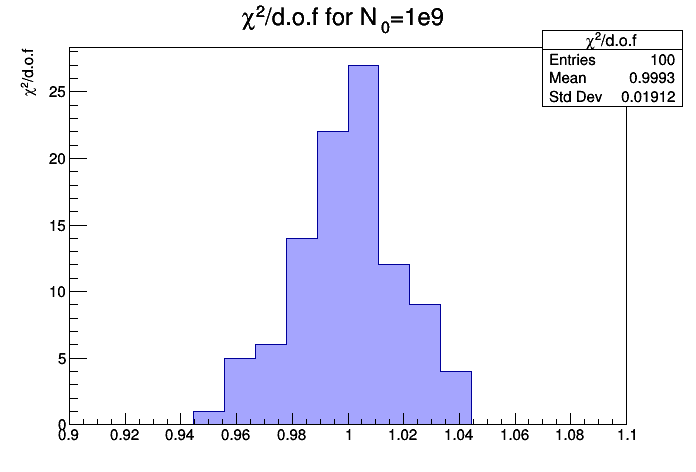

In [118]:
sigma = np.array(sigma)
c = TCanvas()
h = TH1F('#chi^{2}/d.o.f','#chi^{2}/d.o.f for N_{0}=1e9 ',18,0.90,1.10)
for i in range(NUMB):
    h.Fill(sigma[i])
h.SetFillColorAlpha(kBlue, 0.35);
#g.GetXaxis().SetTitle('gamma')
h.GetYaxis().SetTitle('#chi^{2}/d.o.f')
c.Draw()
h.Draw()

In [15]:
print min(ppm),max(ppm)

0.16136172964552176 0.19353149787396903


Warning in <TROOT::Append>: Replacing existing TH1: #delta #omega_{a}/#omega_{a} (Potential memory leak).


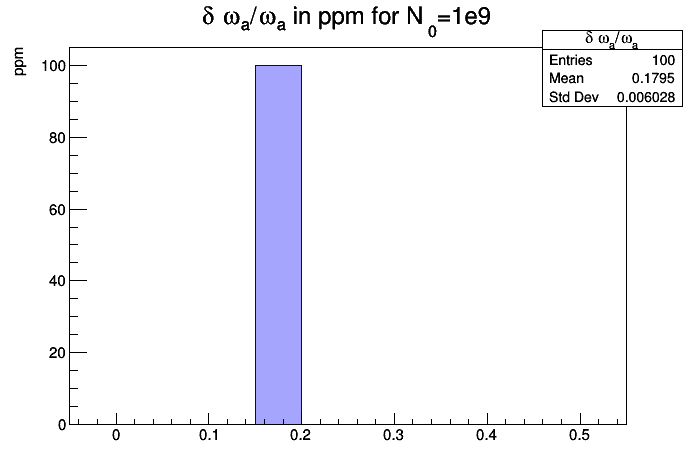

In [14]:
ppm = np.array(ppm)
c = TCanvas()
h = TH1F('#delta #omega_{a}/#omega_{a}','#delta #omega_{a}/#omega_{a} in ppm for N_{0}=1e9',12,-.05,0.55)
for i in range(NUMB):
    h.Fill(ppm[i])
h.SetFillColorAlpha(kBlue, 0.35);
h.GetYaxis().SetTitle('ppm')
c.Draw()
h.Draw()


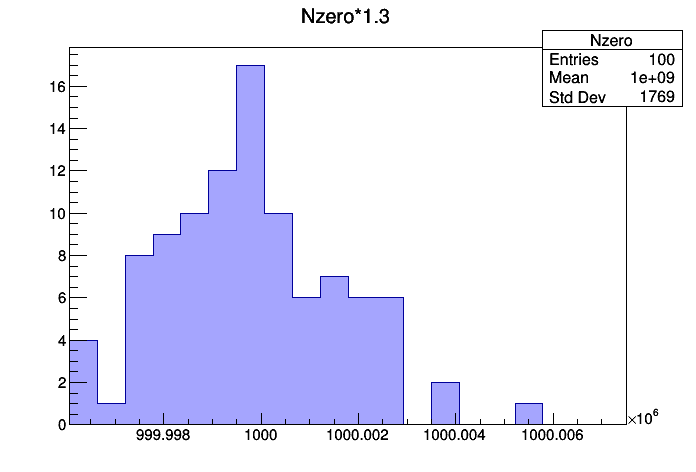

In [136]:
c = TCanvas()
h = TH1F("Nzero","Nzero*1.3",20,min(Nzero),max(Nzero))
for k in range(NUMB):
    h.Fill(Nzero[k] )
h.SetFillColorAlpha(kBlue, 0.35);
c.Draw()
h.Draw() 

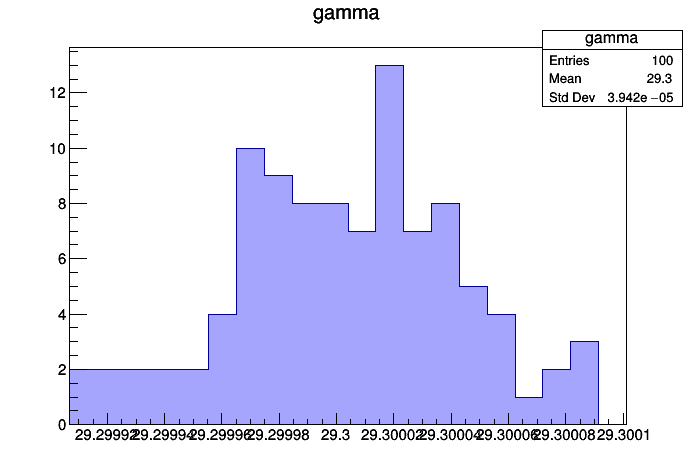

In [137]:
c = TCanvas()
h = TH1F("gamma","gamma",20,min(GAMMA),max(GAMMA))
for k in range(NUMB):
    h.Fill(GAMMA[k] )
h.SetFillColorAlpha(kBlue, 0.35);
c.Draw()
h.Draw() 

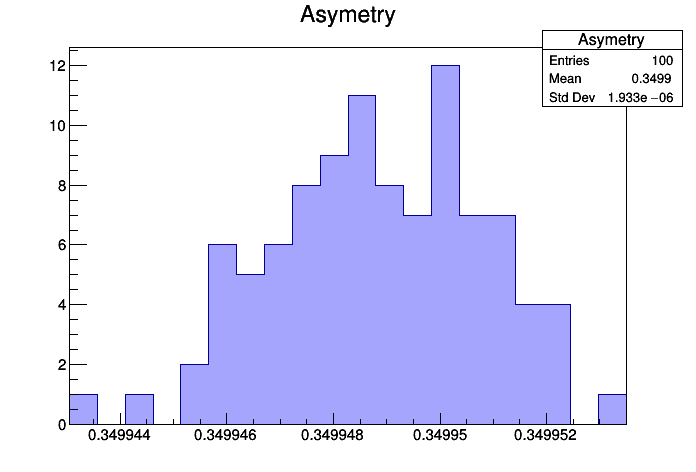

In [138]:
c = TCanvas()
h = TH1F("Asymetry","Asymetry",20,min(ASYM),max(ASYM))
for k in range(NUMB):
    h.Fill(ASYM[k] )
h.SetFillColorAlpha(kBlue, 0.35);
c.Draw()
h.Draw() 

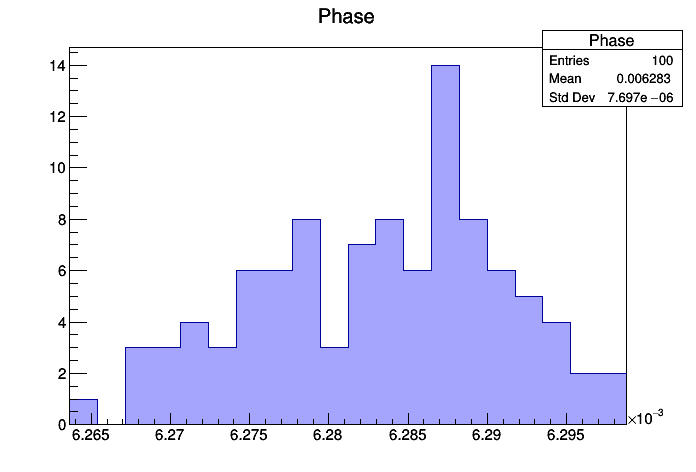

In [139]:
c = TCanvas()
h = TH1F("Phase","Phase",20,min(PHASE),max(PHASE))
for k in range(NUMB):
    h.Fill(PHASE[k] )
h.SetFillColorAlpha(kBlue, 0.35);
c.Draw()
h.Draw() 